# Constructing Paper Trees from Raw LaTeX

In [1]:
import regex as re
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import pickle
import paper_tree
import os
import torch
torch.cuda.empty_cache()
import importlib
importlib.reload(paper_tree)

dir_expanded_tex = "../data/expanded_tex/"
dir_abstracts = "../data/abstracts/"
dir_paper_trees = "./saved_paper_trees/paper_trees/"

In [2]:
os.makedirs(dir_paper_trees, exist_ok=True)
def tex_to_paper_tree(filename):
    with open(dir_abstracts + filename) as file:
        abstract = file.read()
    with open(dir_expanded_tex + filename) as file:
        full_tex = file.read()
    full_tex = paper_tree.clean_junk(full_tex)
    # Build the Paper Tree object
    paper = paper_tree.PaperTree(filename, full_tex, abstract = abstract, section_max_tokens = 500)
    # Clean up all empty sections, expand subsections if the paper is in 'Letter' format
    paper_tree.remove_empty_sections(paper)
    paper_tree.fix_letter_subsections(paper)
    paper_tree.collapse_lone_subsections(paper)
    return paper

filenames = list(filter(lambda str : (".tex" in str[-4:]), os.listdir(dir_expanded_tex)))

papers = []
with ThreadPoolExecutor(max_workers = 20) as executor:
    futures = [executor.submit(tex_to_paper_tree, filename) for filename in filenames]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
        paper = future.result()
        papers.append(paper)

Processing:   0%|          | 0/781 [00:00<?, ?it/s]

Processing: 100%|██████████| 781/781 [00:21<00:00, 35.62it/s]


#### Some elements do not have easily parsed captions, need to manually find them

In [57]:
no_caption = []

def build_no_caption(paper, no_caption):
    for section in paper.sections:
        build_no_caption(section, no_caption)
    if paper.abstract is not None:
        if any([e in paper.title for e in ["figure", "table", "sidewaystable"]]):
            if len(paper.abstract) < 10:
                no_caption.append(paper)

for paper in papers:
    build_no_caption(paper, no_caption)

len(no_caption)

3

In [58]:
# FOR \paperCaption{YEAR}:
"""
Signal yields obtained for the 2012b category from the
simultaneous fit to the data.
The yields shown are those obtained when fitting the data sample
selected using the BDT optimisation chosen for the given decay mode.
The uncertainties are statistical only.
The average selection efficiencies, described in
Sec.~\ref{sec:Efficiencies}, are also shown for each decay mode
together with the corresponding total uncertainty due to the limited
simulation sample size and systematic effects in their determination.
"""

# FOR \resultstable:
"""
Summary of $P_c^+$ properties. The central values are based on the fit displayed in Fig.~\ref{fig:defaultFit}.
"""

for element in no_caption:
    id = element.title
    parent = element.parent
    while parent is not None:
        id = f"{parent.title} --> {id}"
        parent = parent.parent
    print("For Element: ", id)
    print("Element Text: ", element.text)
    print("Current Caption: ", element.abstract)
    caption = input(f"Please manually enter the caption. Enter CANCEL to skip manually finding captions.")
    if caption.lower() == "cancel":
        break
    element.abstract = caption

For Element:  1707.01665.tex --> Appendix --> Fit results by category --> table 0
Element Text:  [htb] \paperCaption{2011} \begin{center} \begin{tabular}{l | >{\hfill} p{0.9cm}@{$\,\pm\,$}p{0.5cm} >{\hfill} p{1.25cm}@{$\,\pm\,$}p{1.25cm} | >{\hfill} p{0.9cm}@{$\,\pm\,$}p{0.5cm} >{\hfill} p{1.25cm}@{$\,\pm\,$}p{1.25cm} } & \multicolumn{4}{c|}{\DD} & \multicolumn{4}{c}{\LL} \\ Decay & \multicolumn{2}{c}{Yield} & \multicolumn{2}{c|}{Efficiency (\%)} & \multicolumn{2}{c}{Yield} & \multicolumn{2}{c}{Efficiency (\%)} \\ \hline \BdtoKsPiPi & $803$ & $36$ & $0.0488$ & $0.0093$ & $471$ & $27$ & $0.0188$ & $0.0036$ \\ \BdtoKsKK & $281$ & $19$ & $0.0292$ & $0.0063$ & $222$ & $17$ & $0.0157$ & $0.0034$ \\ \BstoKsKPi & $333$ & $23$ & $0.0361$ & $0.0064$ & $207$ & $16$ & $0.0148$ & $0.0025$ \\ \BdtoKsKPi & $76$ & $13$ & $0.0322$ & $0.0063$ & $50$ & $9$ & $0.0174$ & $0.0034$ \\ \BstoKsPiPi & $43$ & $10$ & $0.0316$ & $0.0051$ & $21$ & $8$ & $0.0160$ & $0.0025$ \\ \BstoKsKK & $5$ & $3$ & $0.0244$ & $0.

In [ ]:
# SAVE ALL PAPER TREES
os.makedirs(dir_paper_trees, exist_ok = True)
for paper in papers:
    with open(dir_paper_trees + paper.title[:-4] + ".pkl", "wb") as f:
        pickle.dump(paper, f)

## Section-level Abstract Generation with Summarization Models

In [2]:
import regex as re
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import pickle
import paper_tree
import os
import torch
torch.cuda.empty_cache()
import importlib
importlib.reload(paper_tree)
dir_expanded_tex = "../data/expanded_tex/"
dir_abstracts = "../data/abstracts/"
dir_paper_trees = "./saved_paper_trees/paper_trees/"

# Directory to write sumarized paper trees
dir_summarized_paper_trees = "./saved_paper_trees/summarized_openai_paper_trees/"

### Load paper trees to be summarized

In [ ]:
load_dir = dir_summarized_paper_trees

# LOAD ALL PAPER TREES
filenames = list(filter(lambda str : (".pkl" in str[-4:]), os.listdir(load_dir)))
papers = []
for filename in filenames:
    with open(load_dir + filename, "rb") as f:
        paper = pickle.load(f)
        papers.append(paper)

# For any section with no children, the abstract is just equal to the text
def give_abstract(paper):
    if paper.abstract is None and len(paper.sections) == 0:
        paper.abstract = paper.text
    for section in paper.sections:
        give_abstract(section)
for paper in papers:
    give_abstract(paper)

#### Method 1: Summarize with ChatGPT 4o-mini

In [ ]:
from llama_index.llms.openai import OpenAI
import asyncio
import nest_asyncio
nest_asyncio.apply()

llm = OpenAI(temperature=0, model="gpt-4o-mini")

def get_prompt(excerpt):
    prompt = f"""
    Instruction:
    You are an expert in particle physics and machine learning. Your task is to give a 400-token summary of the following excerpt, preserving all key details that would be needed for using this summary for cosine-similarity search with sentence embeddings.

    ### Guidelines:
    Exclude Redundant Content - Do not include background information about the LHC or LHCb detector, citations, or general particle physics knowledge.
    Preserve Important Information - Retain experimental results, theoretical conclusions, and key terminology (e.g., particle names, detector specifics, statistical methods).
    Describe all formulas in words - Avoid including raw mathematical expressions, as they cannot be effectively indexed by a RAG system. Instead, provide a clear verbal explanation of a formula's significance in the context of the excerpt.
    Maintain Technical Precision - Avoid oversimplification of physics concepts; the summary should be useful for physicists querying a RAG system.
    Format Clearly - Use concise technical language, structured paragraphs, and bullet points if necessary for clarity.
    400 Tokens Max - Ensure the output remains under 400 tokens while fully capturing the core findings of the text.

    ### Paper Excerpt:
    {excerpt}

    Output the summary below.
    """
    return prompt       

async def summarize(paper):
    text = ""
    for section in paper.sections:
        elements = ["figure", "table", "sidewaystable"]
        if any([element in section.title for element in elements]):
            text += f"{section.title} caption: {section.abstract} \n"
        else:
            text += f"{section.abstract} \n"
    return await llm.acomplete(get_prompt(text))

async def main(to_be_summarized):
    tasks = [summarize(paper) for paper in to_be_summarized]
    results = await asyncio.gather(*tasks)
    for paper, result in zip(to_be_summarized, results):
        paper.abstract = result.text

def build_to_be_summarized(paper, to_be_summarized):
    if paper.abstract is None:
        can_be_summarized = True
        for section in paper.sections:
            if section.abstract is None:
                can_be_summarized = False
        
        if can_be_summarized:
            to_be_summarized.append(paper)

    for section in paper.sections:
        build_to_be_summarized(section, to_be_summarized) 

In [9]:
import time
os.makedirs(dir_summarized_paper_trees, exist_ok=True)

to_be_summarized = [None]
while len(to_be_summarized) > 0:
    to_be_summarized = []
    for paper in papers:
        build_to_be_summarized(paper, to_be_summarized)
    print(len(to_be_summarized))
    to_be_summarized = to_be_summarized[0:50]
    asyncio.run(main(to_be_summarized))

    for paper in papers:
        with open(dir_summarized_paper_trees + paper.title[:-4] + ".pkl", "wb") as f:
            pickle.dump(paper, f)

    time.sleep(30)

283
235
188
143
97
53
9
2
0


#### Method 2: Summarize with bart-large-cnn

In [ ]:
needs_abstract = []
def build_needs_abstract(paper, needs_abstract):
    for section in paper.sections:
        build_needs_abstract(section, needs_abstract)
    if paper.abstract is None:
        needs_abstract.append(paper)

for paper in papers:
    build_needs_abstract(paper, needs_abstract)

len(needs_abstract)

In [376]:
from transformers import BartTokenizer
import math
torch.cuda.empty_cache() 

MAX_SUMMARY_LENGTH = 300
BART_MAX_TOKENS = 1024

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
# Function to split the text into chunks with overlap
def split_into_chunks(text, max_length = BART_MAX_TOKENS - MAX_SUMMARY_LENGTH):
    # Tokenize the text into tokens
    tokens = tokenizer.encode(text, truncation=False)

    # Calculate the ideal chunk size (as equal as possible)
    chunk_size = math.ceil(len(tokens) / math.ceil(len(tokens) / max_length))

    # Calculate how many chunks are needed
    num_chunks = math.ceil(len(tokens) / chunk_size)

    chunks = []
    start_idx = 0

    for _ in range(num_chunks):
        end_idx = start_idx + chunk_size
        chunk = tokens[start_idx:end_idx]
        chunks.append(chunk)

        # Update start_idx for the next chunk
        start_idx = end_idx

    # Decode chunks back to text
    chunk_texts = [tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]

    return chunk_texts, len(tokens)

from transformers import pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device="cuda")

Device set to use cuda


In [ ]:
i = 0
for section in tqdm(needs_abstract, desc="Processing sections", unit="section"):
    string = ""
    for subsection in section.sections:
        string += (subsection.abstract + " ")
        
    chunked_string, num_tokens = split_into_chunks(string)
    tqdm.write(f"Processing section: {section} | Number of chunks: {len(chunked_string)}")

    # Excerpt is small enough that summarization is not needed.
    if num_tokens < MAX_SUMMARY_LENGTH:
        section.abstract = string
    else:    
        summaries = summarizer(chunked_string, max_length = max(MAX_SUMMARY_LENGTH // len(chunked_string), 100), min_length = 50)
        section.abstract = "".join([summary['summary_text'] + " " for summary in summaries])

    if i % 50 == 0:
        for paper in papers:
            with open(dir_summarized_paper_trees + paper.title[:-4] + ".pkl", "wb") as f:
                pickle.dump(paper, f)
        torch.cuda.empty_cache()
        summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device="cuda")
    i += 1

Processing sections:   0%|          | 0/6149 [00:00<?, ?section/s]

Processing section: 2110.00831.tex --> Characterisation and results | Number of chunks: 2


Device set to use cuda
Processing sections:   0%|          | 1/6149 [00:13<23:11:12, 13.58s/section]

Processing section: 2110.00831.tex --> Mitigation strategies | Number of chunks: 1


Processing sections:   0%|          | 2/6149 [00:14<10:12:59,  5.98s/section]

Processing section: 2110.00831.tex --> Effects on the PID performance | Number of chunks: 1


Processing sections:   0%|          | 3/6149 [00:14<5:58:38,  3.50s/section] 

Processing section: 1505.01654.tex --> Determination of signal yield | Number of chunks: 1
Processing section: 2103.11058.tex --> Introduction | Number of chunks: 1


Processing sections:   0%|          | 5/6149 [00:15<2:58:08,  1.74s/section]

Processing section: 2103.11058.tex --> Signal modes and fit model | Number of chunks: 1


Processing sections:   0%|          | 6/6149 [00:16<2:22:37,  1.39s/section]

Processing section: 2309.05514.tex --> Analysis overview | Number of chunks: 1


Processing sections:   0%|          | 7/6149 [00:16<1:58:11,  1.15s/section]

Processing section: 2309.05514.tex --> Fit to determine the \texorpdfstring{\textbf{\CP}}{CP} violation observables | Number of chunks: 1


Processing sections:   0%|          | 8/6149 [00:17<1:53:52,  1.11s/section]

Processing section: 2309.05514.tex --> Appendix | Number of chunks: 1
Processing section: 1403.1339.tex --> Introduction | Number of chunks: 1
Processing section: 2201.03497.tex --> Headers | Number of chunks: 2


Processing sections:   0%|          | 10/6149 [00:20<3:26:22,  2.02s/section]


### Testing

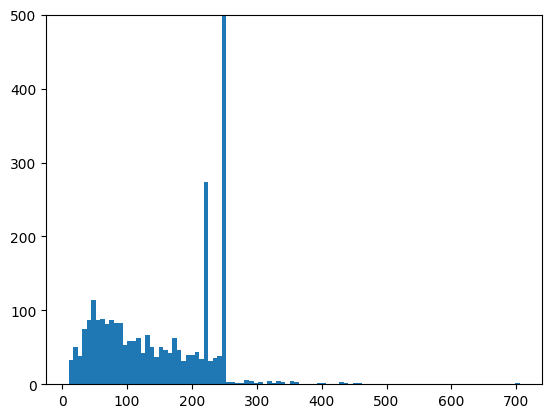

In [99]:
ab_len = []
ab_section = []

def build_ab_len(paper):
    for section in paper.sections:
        build_ab_len(section)
    if paper.abstract is not None:
        ab = paper.abstract
        ab_len.append(len(tokenizer.encode(ab, truncation=False)))
        ab_section.append(paper)

for i, paper in enumerate(papers):
    build_ab_len(paper)
    if i > 100:
        break

import matplotlib.pyplot as plt
plt.hist(ab_len, bins = 100)
plt.ylim(0, 500)
None

In [111]:
print(f"Max Chunk Length (chars): {max(ab_len)}")
max_sec_idx = ab_len.index(max(ab_len))
max_sec = ab_section[max_sec_idx]
max_sec_id = max_sec.title
parent = max_sec.parent
while parent is not None:
    max_sec_id = f"{parent.title} --> {max_sec_id}"
    parent = parent.parent
print(f"Section: {max_sec_id} \n Text: {max_sec.abstract}")

ab_len.pop(max_sec_idx)
ab_section.pop(max_sec_idx)

print("\n\n")

print(f"Min Chunk Length (chars): {min(ab_len)}")
min_sec_idx = ab_len.index(min(ab_len))
min_sec = ab_section[min_sec_idx]
min_sec_id = min_sec.title
parent = min_sec.parent
while parent is not None:
    min_sec_id = f"{parent.title} --> {min_sec_id}"
    parent = parent.parent
print(f"Section: {min_sec_id} \n Text: {min_sec.abstract}")

ab_len.pop(min_sec_idx)
ab_section.pop(min_sec_idx)

None

Max Chunk Length (chars): 2115
Section: 2412.09414.tex --> Headers --> Chunk 11 
 Text:  used to correct the five-dimensional decay model of the corresponding dielectron mode.
In addition, particle-identification, hardware-trigger, and tracking efficiencies as well as the dielectron-mass resolution are corrected using dedicated control channels in data. 
Systematic uncertainties related to the determination of the yields arise due to limited knowledge of the various fit components and are evaluated using pseudoexperiments, where alternative fit models are tested. These include variations of the signal and background shape parameters within the uncertainties determined from the fits to simulation, and a signal shape obtained with a modified electron momentum resolution. In addition, a Bukin distribution is tested as an alternative distribution to represent the signal. Since not all selection criteria can be applied to background simulation because of limited simulated sample sizes, the 